In [1]:
import torch
from torch.utils.data import DataLoader
import os 
import cv2


In [2]:
from torchvision import transforms

def load_images(image_folder):
    images = {}
    for filename in os.listdir(image_folder):
        if filename.endswith('_test.jpg'):
            file_id = filename.split('_')[0]
            full_path = os.path.join(image_folder, filename)
            image = cv2.imread(full_path)  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
            image_tensor = transforms.ToTensor()(image)  
            images[file_id] = image_tensor
    return images

In [3]:
def parse_annotations(annotation_folders):
    annotations = {}
    for file in os.listdir(annotation_folders):
        if file.endswith('.txt'):
            file_id = os.path.splitext(file)[0]
            file_path = os.path.join(annotation_folders, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                bbox_data = []
                labels = []
                for line in lines:
                    x1, y1, x2, y2, damage_type = map(int, line.split())
                    bbox_data.append([x1, y1, x2, y2]) 
                    labels.append(damage_type) 

                bbox_tensor = torch.tensor(bbox_data, dtype=torch.float32) 
                labels_tensor = torch.tensor(labels, dtype=torch.int64)  
                annotations[file_id] = {'boxes': bbox_tensor, 'labels': labels_tensor}
    return annotations

In [4]:
annotations = parse_annotations("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/group00041/00041_not")
dataset_image  = load_images("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/group00041/00041")
merged_dict = {img_id: (dataset_image[img_id], annotations[img_id]) for img_id in dataset_image if img_id in annotations}

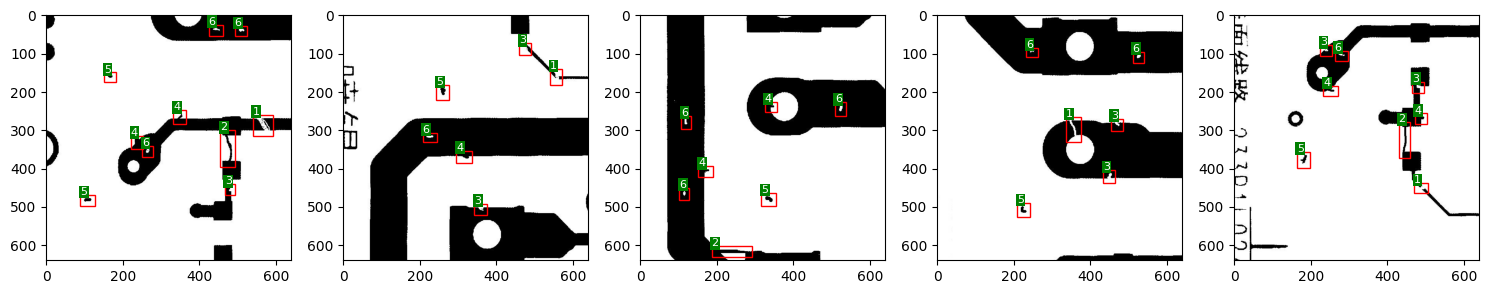

In [5]:
import matplotlib.pyplot as plt
from matplotlib import patches

num_images_to_display = 5

fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i, image_id in enumerate(list(merged_dict.keys())[:num_images_to_display]):
    image_tensor, annotations = merged_dict[image_id]

    boxes = annotations['boxes']
    labels = annotations['labels']
    image_tensor = image_tensor.permute(1, 2, 0)
    image_np = image_tensor.numpy()
    
    ax = axs[i]
    ax.imshow(image_np)
    
    for bbox, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))
    
    ax.axis('on')

plt.tight_layout()
plt.show()


In [6]:
from torch.utils.data import Dataset

class PCBDefectDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (dict): A dictionary where keys are image IDs and values are tuples,
                         with the first element being the image tensor and the second
                         being the annotation dictionary containing 'boxes' and 'labels'.
            transform (callable, optional): Optional transform to be applied on the image.
        """
        self.data = data
        self.ids = list(data.keys())  
        self.transform = transform 

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        image, targets = self.data[img_id] 

        if self.transform:
            image = self.transform(image)  
        return image, targets


In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

def collate_fn(batch):
    images, annotations = zip(*batch)
    return list(images), list(annotations) 

from torch.utils.data import DataLoader, random_split

# Assuming PCBDefectDataset is defined and merged_dict is available
dataset = PCBDefectDataset(merged_dict, transform=None)

# Calculate lengths for splits
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% of dataset
validate_size = int(0.15 * total_size)  # 15% of dataset
test_size = total_size - train_size - validate_size  # Remaining data for testing

# Split the dataset
train_dataset, validate_dataset, test_dataset = random_split(dataset, [train_size, validate_size, test_size])

batch_s = 1
# Create DataLoader for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True, collate_fn=collate_fn)
validate_loader = DataLoader(validate_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)

# test image 
subset_indices = [0,1]
train_subset = Subset(dataset, subset_indices)
train_loader_single = DataLoader(train_subset, batch_size=batch_s, shuffle=True, collate_fn=collate_fn)




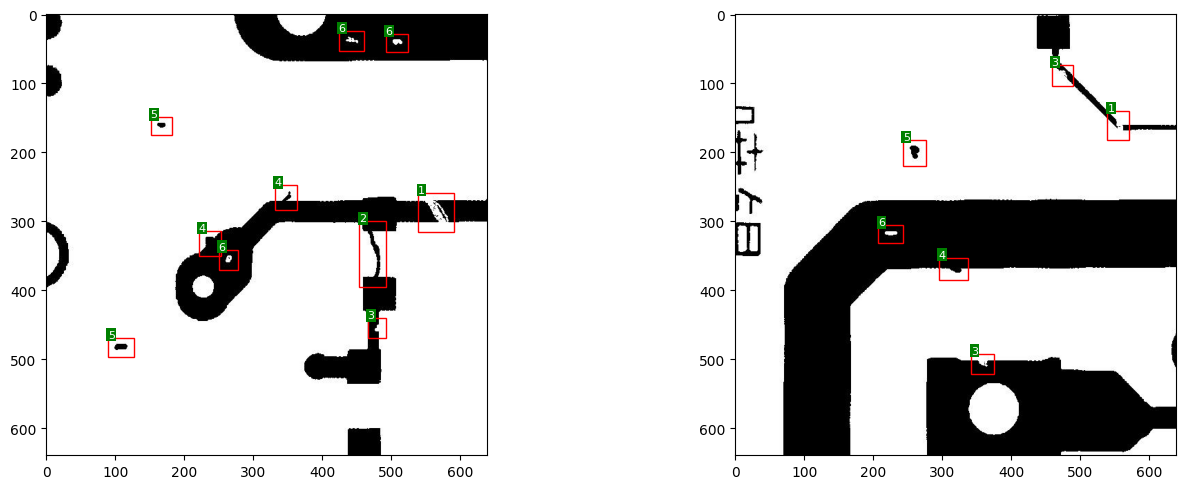

In [8]:
num_images_to_display = 2

fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    image_tensor, annotations = train_subset[i]
    
    boxes = annotations['boxes']
    gt_labels = annotations['labels']

    image_tensor = image_tensor.permute(1, 2, 0)
    image_np = image_tensor.numpy()

    
    ax = axs[i]
    ax.imshow(image_np)
    
    for bbox, label in zip(boxes, gt_labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))


    ax.axis('on')

plt.tight_layout()
plt.show()

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 7  # 6 object classes + 1 background

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
print(torch.version.cuda)
if torch.cuda.is_available():
    print("CUDA is available. Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")


12.1
CUDA is available. Device name: NVIDIA GeForce RTX 3080 Ti


In [12]:
# from torch.optim import SGD

# train_losses_list = []
# validate_losses_list =[]

# num_epochs = 100
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=1e-6)
# model.to(device)

# img_limit = 10

# for epoch in range(num_epochs):
#     epoch_loss = 0
#     train_loss = 0
#     images_processed = 0
#     img_count = 0
#     for data in train_loader_single:
#         imgs = []
#         targets = []
#         for d in train_subset:
#             if (img_count > img_limit): 
#                 break
#             img_count += 1
#             imgs.append(d[0][0].to(device))
#             print(imgs[0].shape)
#             targ = {}
#             targ["boxes"] = d[1]["boxes"].to(device)
#             targ["labels"] = d[1]["labels"].to(device)
#             targets.append(targ)
#         loss_dict = model(imgs, targets)
#         loss = sum(v for v in loss_dict.values())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#         images_processed += len(imgs)

#         avg_train_loss = train_loss / images_processed
#         print(f"Epoch {epoch}: Training Loss: {avg_train_loss}")
#         train_losses_list.append(avg_train_loss)
#     # Validation phase
#     model.eval()
#     epoch_val_loss = 0
#     val_images_processed = 0
#     with torch.no_grad():
#         for data in validate_dataset:
#             imgs = [d[0].to(device) for d in data]
#             targets = [{k: v.to(device) for k, v in d[1].items()} for d in data]
#             loss_dict = model(imgs, targets)
#             loss = sum(v for v in loss_dict.values())
#             epoch_val_loss += loss.item()
#             val_images_processed += len(imgs)

#     avg_val_loss = epoch_val_loss / val_images_processed
#     validate_losses_list.append(avg_val_loss)

#     print(f" Validation Loss: {avg_val_loss}")


In [13]:
print(train_subset[0][0].shape)

torch.Size([3, 640, 640])


In [14]:
from torch.optim import SGD

train_losses_list = []
validate_losses_list =[]

num_epochs = 1
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=1e-6)
model.to(device)


for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_loader:
        imgs = []
        targets = []
        for d in train_dataset:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["labels"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss +=loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}: Training Loss: {epoch_loss}")
        train_losses_list.append(epoch_loss)
    # Validation phase
    # model.eval()
    # epoch_val_loss = 0
    # val_images_processed = 0
    # with torch.no_grad():
    #     for data in validate_dataset:
    #         imgs = [d[0].to(device) for d in data]
    #         targets = [{k: v.to(device) for k, v in d[1].items()} for d in data]
    #         loss_dict = model(imgs, targets)
    #         loss = sum(v for v in loss_dict.values())
    #         epoch_val_loss += loss.item()
    #         val_images_processed += len(imgs)

    # avg_val_loss = epoch_val_loss / val_images_processed
    # validate_losses_list.append(avg_val_loss)

    # print(f" Validation Loss: {avg_val_loss}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.88 GiB. GPU 0 has a total capacity of 12.00 GiB of which 0 bytes is free. Of the allocated memory 21.06 GiB is allocated by PyTorch, and 4.47 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

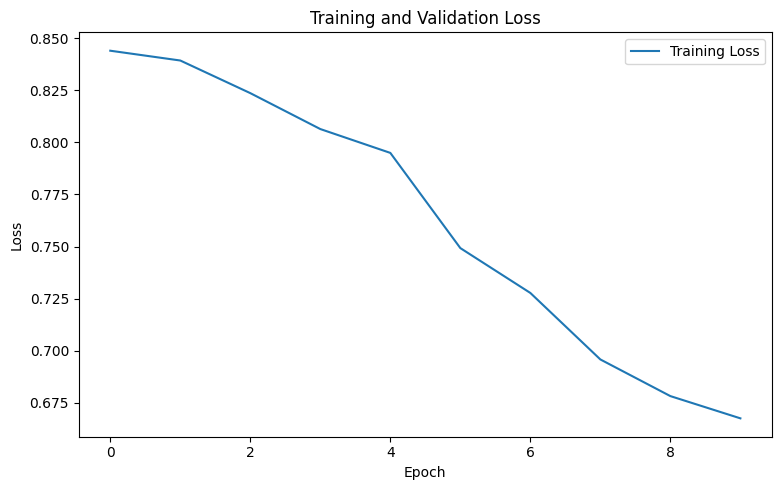

In [31]:
plt.figure(figsize=(15, 5))

# Plot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_list, label='Training Loss')
# plt.plot(validate_losses_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# from torchvision.ops import box_iou
# # import numpy as np 
# # Initialize metrics
# results = []
# pred_ls =[]
# # Initialize containers for metrics
# true_positives = 0
# false_positives = 0
# false_negatives = 0

# # No gradients needed
# with torch.no_grad():
#     for images, targets in train_loader_single:
#         images = [image.to(device) for image in images]  # Move images to the appropriate device
#         outputs = model(images)  # Get model predictions
#         pred_ls.append(outputs)
#         for i, output in enumerate(outputs):
#             # Get predicted and GT boxes and labels
#             pred_boxes = output['boxes']
#             pred_labels = output['labels']
#             pred_scores = output['scores']
            
#             gt_boxes = targets[i]['boxes'].to(device)
#             gt_labels = targets[i]['labels'].to(device)
            
#             # Calculate IoU between GT and predicted boxes
#             iou_matrix = box_iou(pred_boxes, gt_boxes)
#             threshold_iou = 0.5
#             matched_gt = []
            
#             for j, iou in enumerate(iou_matrix):
#                 max_iou, max_index = torch.max(iou, dim=0)
#                 if max_iou >= threshold_iou:
#                     true_pred_label = pred_labels[j]
#                     true_gt_label = gt_labels[max_index]
                    
#                     if true_pred_label == true_gt_label:
#                         true_positives += 1
#                         matched_gt.append(max_index.item())
#                     else:
#                         false_positives += 1
#                 else:
#                     false_positives += 1
            
#             # Any GT box not matched is a false negative
#             false_negatives += len(gt_boxes) - len(set(matched_gt))

# # Calculate precision and recall
# precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
# recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")




In [ ]:
import torchvision.ops

# Prepare the model for evaluation
model.eval()

# Store the passed images, labels, and bounding boxes
stored_results = []

# No gradients needed during inference
with torch.no_grad():
    for image, target in validate_dataset:  # Assuming validation_dataset yields one image, target pair at a time
        # Move the image to the device and add a batch dimension
        image = image.to(device).unsqueeze(0)

        # Perform the prediction
        output = model(image)

        # Extract the predicted boxes, labels, and scores
        out_bbox = output[0]['boxes']
        out_score = output[0]['scores']
        out_labels = output[0]['labels']

        # Apply NMS to the predicted boxes and scores with the threshold
        keep_idx = torchvision.ops.nms(out_bbox, out_score, 0.55)

        # Filter out the predictions with scores below the threshold
        keep_boxes = out_bbox[keep_idx]
        keep_scores = out_score[keep_idx]
        keep_labels = out_labels[keep_idx]

        # Filter based on scores to remove any low confidence detections
        high_score_idx = keep_scores > 0.55
        keep_boxes = keep_boxes[high_score_idx]
        keep_scores = keep_scores[high_score_idx]
        keep_labels = keep_labels[high_score_idx]

        # Print the shapes of the bounding boxes before and after NMS
        print(f'Original bbox shape: {out_bbox.shape}')
        print(f'Keep bbox shape: {keep_boxes.shape}')

        # Store the results
        stored_results.append({
            'image': image.squeeze(0).cpu(),  # Remove batch dimension and move to CPU
            'boxes': keep_boxes.cpu(),  # Move to CPU
            'labels': keep_labels.cpu(),  # Move to CPU
            'scores': keep_scores.cpu()  # Move to CPU
        })